In [1]:
import numpy as np
import pandas as pd
import os
import glob
import torch
import random
from torchvision.ops import nms
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
class DroneDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        self.image_files = glob.glob(os.path.join(dir_path, '*.jpg'))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert("RGB")
        img = cv2.imread(img_name)
        wt = img.shape[1]
        ht = img.shape[0]

        bboxes_file = img_name.replace('.jpg', '.bboxes.tsv')
        if not (os.path.exists(bboxes_file)):
            raise FileNotFoundError(f"Bounding box files not found for {img_name}")

        # Load bounding box annotations from TSV files
        bounding_boxes = pd.read_csv(bboxes_file, sep='\t', header=None)

        boxes = []
        for _, row in bounding_boxes.iterrows():
            xmin, ymin, xmax, ymax = row.values[:4]
            xmin = (xmin/wt) * 256
            xmax = (xmax/wt) * 256
            ymin = (ymin/ht) * 256
            ymax = (ymax/ht) * 256
            boxes.append([float(xmin), float(ymin), float(xmax), float(ymax)])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((bounding_boxes.shape[0],), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        
        return image, target


In [5]:
import os
from PIL import Image

def get_image_dimensions(directory):
    dimensions = []
    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
            try:
                with Image.open(os.path.join(directory, filename)) as img:
                    width, height = img.size
                    dimensions.append((filename, width, height))
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    
    return dimensions

directory = '/kaggle/input/drone-data/Q4/test' 
image_dimensions = get_image_dimensions(directory)
for filename, width, height in image_dimensions:
    print(f"Image: {filename}, Width: {width}, Height: {height}")

Image: test9.jpg, Width: 1677, Height: 1167
Image: test14.jpg, Width: 922, Height: 588
Image: test34.jpg, Width: 1717, Height: 946
Image: test7.jpg, Width: 1497, Height: 970
Image: test13.jpg, Width: 1564, Height: 858
Image: test2.jpg, Width: 1122, Height: 748
Image: test11.jpg, Width: 1759, Height: 895
Image: test24.jpg, Width: 1713, Height: 912
Image: test5.jpg, Width: 1665, Height: 1254
Image: test35.jpg, Width: 1084, Height: 715
Image: test26.jpg, Width: 1488, Height: 963
Image: test25.jpg, Width: 1261, Height: 616
Image: test30.jpg, Width: 1507, Height: 859
Image: test16.jpg, Width: 1747, Height: 1084
Image: test3.jpg, Width: 1591, Height: 919
Image: test17.jpg, Width: 1176, Height: 754
Image: test40.jpg, Width: 1588, Height: 1051
Image: test19.jpg, Width: 1252, Height: 643
Image: test6.jpg, Width: 1536, Height: 1030
Image: test12.jpg, Width: 1099, Height: 814
Image: test23.jpg, Width: 1761, Height: 1153
Image: test18.jpg, Width: 1506, Height: 1018
Image: test28.jpg, Width: 691, H

In [22]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets


train_dir = '/kaggle/input/drone-data/Q4/drones_dataset/train'
validation_dir = '/kaggle/input/drone-data/Q4/drones_dataset/validation'

train_dataset = DroneDataset(train_dir, transform=transform)
validation_dataset = DroneDataset(validation_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False, collate_fn=collate_fn)

In [7]:
for batch_idx, (images, targets) in enumerate(train_loader):
    for target_idx, target in enumerate(targets):
        boxes = target['boxes']
        for box_idx, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            if xmax <= xmin or ymax <= ymin:
                print(f"Invalid bounding box in batch {batch_idx}, target {target_idx}, box {box_idx}: {box}")

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = 2
model = get_model(num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 114MB/s]  


In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        
        # Debugging: print targets before moving to device
#         print(f"Targets before moving to device: {targets}")
        
        # Ensure targets is a list of dictionaries
        if isinstance(targets, dict):
            targets = [targets]

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device
#         print(targets)
#         print('-----------------------------------------------------')
        # Debugging: print targets after moving to device
#         print(f"Targets after moving to device: {targets}")
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        print(loss_dict)
        print('-----------------------------------------------------')
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

    # Update the learning rate
    lr_scheduler.step()

print("Training complete")

{'loss_classifier': tensor(1.5478, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1504, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)}
-----------------------------------------------------
{'loss_classifier': tensor(1.6081, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2680, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0179, device='cuda:0', grad_fn=<DivBackward0>)}
-----------------------------------------------------
{'loss_classifier': tensor(1.5258, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0526, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1388, device='cuda:0',
       gr

In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        
        # Debugging: print targets before moving to device
#         print(f"Targets before moving to device: {targets}")
        
        # Ensure targets is a list of dictionaries
        if isinstance(targets, dict):
            targets = [targets]

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device
#         print(targets)
#         print('-----------------------------------------------------')
        # Debugging: print targets after moving to device
#         print(f"Targets after moving to device: {targets}")
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        print(loss_dict)
        print('-----------------------------------------------------')
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

    # Update the learning rate
    lr_scheduler.step()

print("Training complete")


{'loss_classifier': tensor(1.6292, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0378, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1568, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)}
-----------------------------------------------------
{'loss_classifier': tensor(1.6894, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0267, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2866, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)}
-----------------------------------------------------
{'loss_classifier': tensor(1.5981, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0478, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1196, device='cuda:0',
       gr

In [18]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 2.3 MB/s eta 0:00:0000:0100:01m


[{'boxes': tensor([[ 34.8738, 101.0674,  42.1426, 113.3909],
        [ 34.4747, 102.9947,  48.4492, 107.8535],
        [ 35.7888, 100.2185,  47.5848, 112.7653],
        [ 34.3233, 103.5040,  44.8205, 116.2175],
        [ 34.2602, 103.6127,  39.7876, 115.2975],
        [ 36.1268, 105.0112,  46.9441, 111.1853],
        [ 35.7080, 101.4178,  45.0337, 107.4221],
        [193.9582, 124.4637, 204.7864, 135.6450],
        [ 40.7282, 101.2153,  45.7495, 113.6964],
        [ 38.3323, 100.8077,  45.5298, 118.1677],
        [ 41.3748, 100.5575,  48.5735, 116.8557],
        [196.3838, 118.4663, 203.9224, 136.0297],
        [ 34.9857,  96.9479,  67.8819, 116.4639],
        [ 33.4748, 100.1223,  39.2749, 111.9094],
        [ 35.4803,  97.8408,  42.8566, 109.3696],
        [ 42.2394, 101.5587,  53.0003, 114.7961],
        [195.3905, 129.6315, 202.3542, 152.0008],
        [ 26.9724,  98.3808,  85.8200, 124.5728],
        [172.0085,  96.5157, 214.7118, 136.9790],
        [186.9240, 117.7820, 205.9336, 

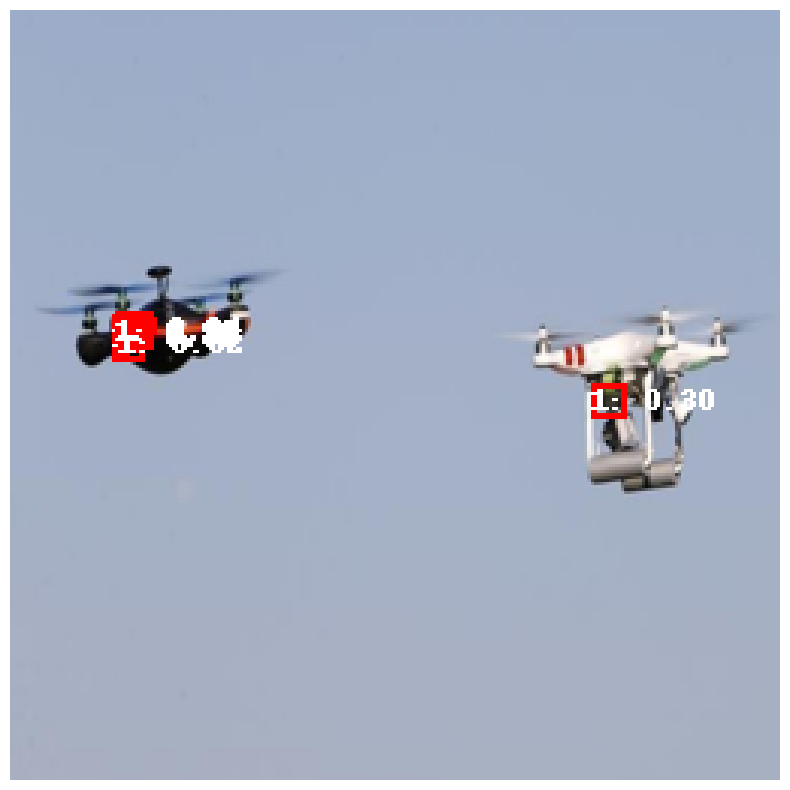

In [13]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = '/kaggle/input/drone-data/Q4/test/test10.jpg'
image = Image.open(image_path).convert("RGB")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)

# Model inference
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)
print(predictions)
# Extract boxes, labels, and scores
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].cpu()
scores = predictions[0]['scores'].cpu()

# Filter boxes, labels, and scores with score > 0.5
threshold = 0.3
high_score_indices = scores > threshold
filtered_boxes = boxes[high_score_indices]
filtered_labels = labels[high_score_indices]
filtered_scores = scores[high_score_indices]

def visualize_image_with_boxes(image, boxes, labels=None, scores=None):
    # Convert image to RGB if not already
    if image.mode != 'RGB':
        image = image.convert("RGB")

    # Draw the bounding boxes on the image
    draw = ImageDraw.Draw(image)
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        
        # Add labels and scores if provided
        if labels is not None and scores is not None:
            label = labels[i].item()
            score = scores[i].item()
            draw.text((xmin, ymin), f"{label}: {score:.2f}", fill="white")

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Convert the tensor image back to PIL image for visualization
image_pil = Image.open(image_path).convert("RGB")
image_resized = image_pil.resize((256, 256))
visualize_image_with_boxes(image_resized, filtered_boxes, filtered_labels, filtered_scores)

[{'boxes': tensor([[184.6230,  38.5975, 239.4891,  67.3362],
        [179.1815,  39.9913, 215.8445,  65.0780],
        [  3.0131,  72.7100,  60.4852, 226.5751],
        [212.4157,  59.4841, 226.5287,  65.1559],
        [194.0375,  43.5612, 218.7663,  71.9769],
        [205.0307,  48.8093, 227.3762,  79.8438],
        [ 18.2273,  88.4004,  77.0522, 180.0562],
        [185.5959,  38.4753, 202.0954,  74.2863],
        [ 15.0588, 163.5107,  21.3603, 169.3842],
        [  0.0000, 109.7006,  86.2413, 203.7794],
        [195.6422,  52.6067, 211.5462,  88.8918],
        [191.3636,  17.6939, 228.6684,  75.7638],
        [163.2613,  36.8521, 227.6218,  64.0820],
        [ 22.8039,  67.5151,  58.4208, 130.2816],
        [189.6356,  55.0744, 223.4022,  72.6466],
        [194.6434,  38.0284, 223.1791,  62.2221],
        [ 27.7429,  80.1071,  73.4222, 126.4752],
        [ 10.4788, 127.0851,  79.6844, 165.4391],
        [205.5708,  42.5949, 233.4034, 103.9694],
        [  0.0000,  12.5756,  92.7206, 

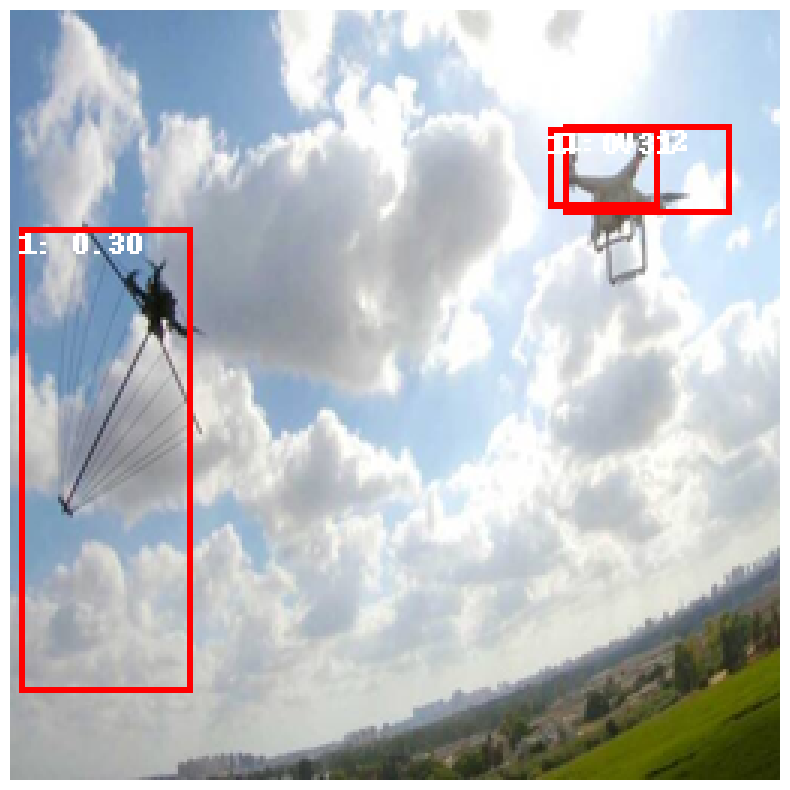

In [15]:
image_path = '/kaggle/input/drone-data/Q4/test/test1.jpg'
image = Image.open(image_path).convert("RGB")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)
# Model inference
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)
print(predictions)
# Extract boxes, labels, and scores
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].cpu()
scores = predictions[0]['scores'].cpu()

# Filter boxes, labels, and scores with score > 0.5
threshold = 0.3
high_score_indices = scores > threshold
filtered_boxes = boxes[high_score_indices]
filtered_labels = labels[high_score_indices]
filtered_scores = scores[high_score_indices]

image_pil = Image.open(image_path).convert("RGB")
image_resized = image_pil.resize((256, 256))
visualize_image_with_boxes(image_resized, filtered_boxes, filtered_labels, filtered_scores)

[{'boxes': tensor([[196.6927, 150.5032, 248.4800, 180.5458],
        [110.2333, 132.1544, 117.9919, 147.0054],
        [201.3308, 152.1074, 229.1102, 171.0327],
        [199.5047, 155.3239, 238.2300, 202.2583],
        [ 90.0286,  24.7198, 119.4814,  82.2067],
        [199.0151, 135.5190, 241.7202, 189.2663],
        [ 69.7232, 192.2945, 106.2899, 228.5394],
        [195.8243, 128.6920, 229.5306, 175.9510],
        [196.8623, 158.9585, 212.1982, 190.1829],
        [110.6423, 131.9674, 122.6464, 142.9227],
        [ 92.4265, 199.7527,  99.3816, 208.2336],
        [109.3200, 130.1851, 119.1303, 140.5554],
        [ 63.8248, 215.1560,  72.8026, 221.1030],
        [185.5765, 143.4261, 243.0446, 207.4317],
        [209.0034, 149.0181, 224.6921, 188.6589],
        [202.7694, 152.3156, 218.2246, 190.1984],
        [ 74.0087,  27.8587, 121.3322,  62.7625],
        [196.1047, 156.3054, 225.4167, 175.6321],
        [ 88.3192,  20.9425, 141.7770,  53.6076],
        [199.6465, 107.9755, 243.8871, 

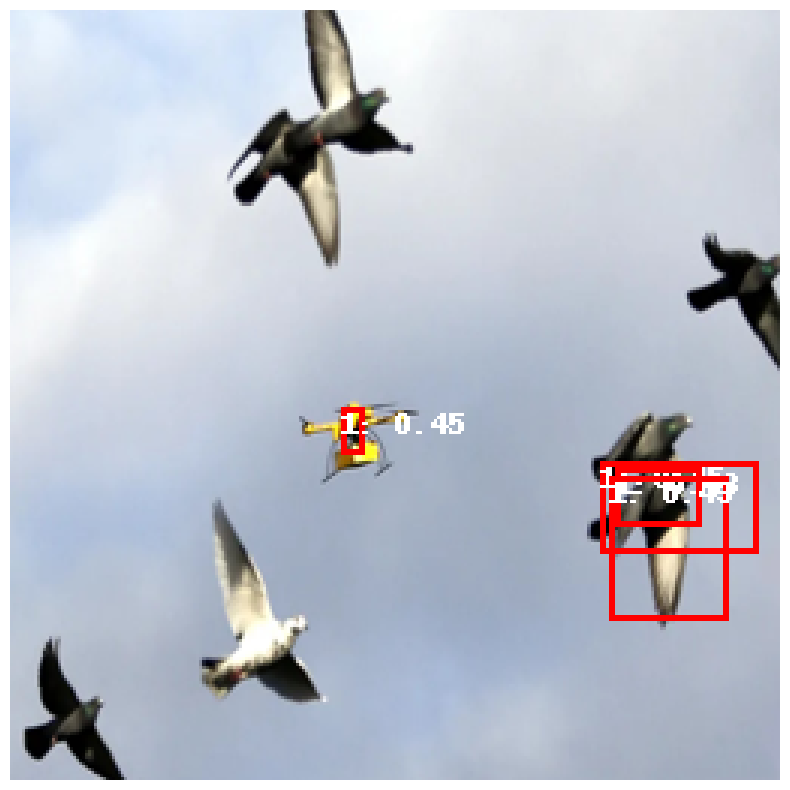

In [25]:
image_path = '/kaggle/input/drone-data/Q4/test/test40.jpg'
image = Image.open(image_path).convert("RGB")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)
# Model inference
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)
print(predictions)
# Extract boxes, labels, and scores
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].cpu()
scores = predictions[0]['scores'].cpu()

# Filter boxes, labels, and scores with score > 0.5
threshold = 0.40
high_score_indices = scores > threshold
filtered_boxes = boxes[high_score_indices]
filtered_labels = labels[high_score_indices]
filtered_scores = scores[high_score_indices]

image_pil = Image.open(image_path).convert("RGB")
image_resized = image_pil.resize((256, 256))
visualize_image_with_boxes(image_resized, filtered_boxes, filtered_labels, filtered_scores)

[{'boxes': tensor([[118.4339,  65.5123, 167.5198, 117.2775],
        [120.4763,  59.1460, 192.0067,  93.7014],
        [151.4041,  78.8661, 165.4239, 113.1573],
        [110.1079,  47.2561, 222.5379, 104.8027],
        [130.0340,  46.9257, 161.4535, 114.9892],
        [157.3724,  85.5576, 163.8636, 107.3476],
        [154.6784,  86.5745, 163.2470,  97.6441],
        [108.0423,  65.1083, 160.0801, 208.5530],
        [150.5984,  54.7389, 181.5799, 121.9742],
        [ 94.1185,  39.4946, 238.0565,  85.6690],
        [117.3436,  48.1537, 174.1133, 175.2240],
        [111.7644,  47.9725, 192.5051,  79.5144],
        [153.3627,  88.2894, 164.5707, 104.5790],
        [151.8165,  87.1030, 158.6246, 105.1818],
        [148.0472,  82.8513, 164.0238, 126.2871],
        [177.7611,  62.8809, 185.0028,  73.7821],
        [103.7094,  62.1383, 167.8824,  96.9519],
        [112.0892,  38.6710, 137.9834, 103.7410],
        [ 94.6043,  36.3181, 184.3196, 120.2183],
        [139.7410,  48.2205, 171.7240, 

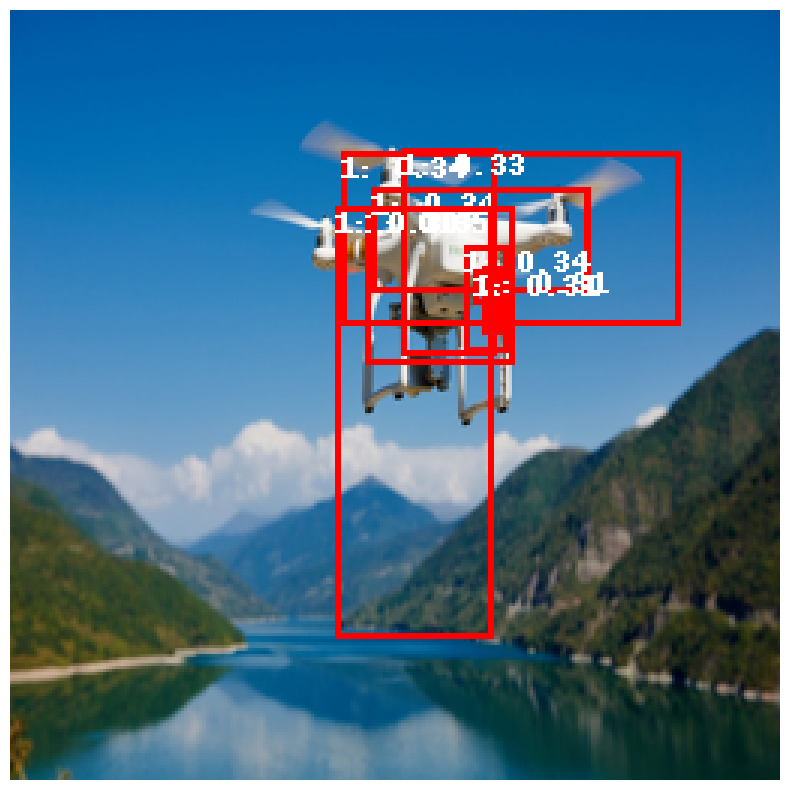

In [29]:
image_path = '/kaggle/input/drone-data/Q4/test/test26.jpg'
image = Image.open(image_path).convert("RGB")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)
# Model inference
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)
print(predictions)
# Extract boxes, labels, and scores
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].cpu()
scores = predictions[0]['scores'].cpu()

# Filter boxes, labels, and scores with score > 0.5
threshold = 0.30
high_score_indices = scores > threshold
filtered_boxes = boxes[high_score_indices]
filtered_labels = labels[high_score_indices]
filtered_scores = scores[high_score_indices]

image_pil = Image.open(image_path).convert("RGB")
image_resized = image_pil.resize((256, 256))
visualize_image_with_boxes(image_resized, filtered_boxes, filtered_labels, filtered_scores)

[{'boxes': tensor([[ 84.0151, 111.4299, 126.9673, 164.4011],
        [165.9962,  92.9572, 182.9213, 133.8260],
        [164.5102,  66.5380, 189.2799, 143.5884],
        [148.3376,  49.5571, 224.6429, 226.1694],
        [163.5931,  84.4864, 177.1318, 121.8867],
        [166.2127,  86.1532, 188.5056, 109.3774],
        [ 85.5122, 104.6530, 117.4615, 141.7090],
        [170.7119, 144.4472, 220.9712, 172.1088],
        [ 32.1151,  75.0930, 234.0217, 133.1378],
        [169.8773,  84.0818, 192.5816, 162.5174],
        [ 65.5865, 101.1120, 256.0000, 208.7755],
        [ 19.8990,  47.3743, 256.0000, 192.0750],
        [177.7341, 136.5989, 201.5113, 195.6276],
        [ 36.3249,  17.8067, 124.0825, 123.7893],
        [ 92.9458, 117.4706, 115.5606, 144.7933],
        [ 46.6123,  76.6351, 156.0424, 194.6387],
        [ 78.9833,  92.1218, 109.3361, 168.2670],
        [156.8206,  84.4876, 180.5671, 150.7092],
        [ 77.1100, 117.8753, 135.6046, 146.1304],
        [158.4398,   0.0000, 249.1542, 

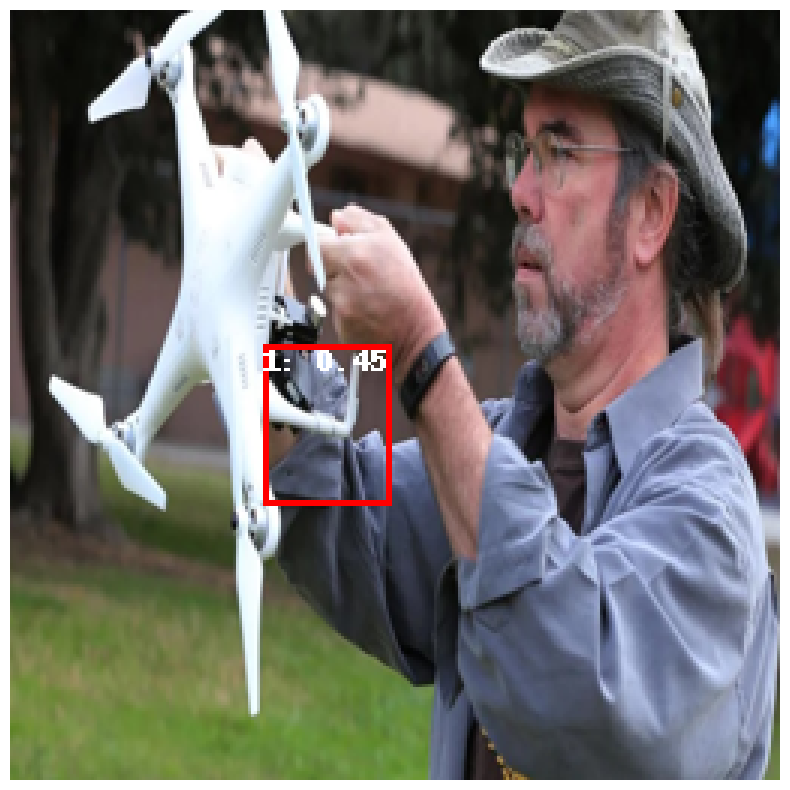

In [38]:
image_path = '/kaggle/input/drone-data/Q4/test/test3.jpg'
image = Image.open(image_path).convert("RGB")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)
# Model inference
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)
print(predictions)
# Extract boxes, labels, and scores
boxes = predictions[0]['boxes'].cpu()
labels = predictions[0]['labels'].cpu()
scores = predictions[0]['scores'].cpu()

# Filter boxes, labels, and scores with score > 0.5
threshold = 0.45
high_score_indices = scores > threshold
filtered_boxes = boxes[high_score_indices]
filtered_labels = labels[high_score_indices]
filtered_scores = scores[high_score_indices]

image_pil = Image.open(image_path).convert("RGB")
image_resized = image_pil.resize((256, 256))
visualize_image_with_boxes(image_resized, filtered_boxes, filtered_labels, filtered_scores)